In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
from src.utils import get_generations, get_all, get_empirical_cdf, print_random_examples, get_auc

In [17]:
def _get_params_llama(dirname):
    """
    Given a directory name, returns the model parameters and variance as saved in the directory name
    """
    span = re.search('lay_-?\d+', dirname).span(0)

    var_span = re.search('var_\de-?\d+', dirname).span(0)
    variance = float(dirname[var_span[0]+4:var_span[1]])

    param_info = dirname[span[0]+4:var_span[0]-1]
    if len(param_info) == 0:
        param_info = '-1_mlp_weight'
        if '_ran_' in dirname:
            span = re.search('ran_\d+', dirname).span(0)
            param_info += '_r' + dirname[span[0]:span[1]]
        else:
            param_info += '_r0'
        return param_info, variance

    if '_ran_' in dirname:
        span = re.search('ran_\d+', dirname).span(0)
        param_info += '_r' + dirname[span[0]+4:span[1]]
    else:
        param_info += '_r0'


    return param_info, variance

def _get_rank(param_info):
    """
    Given a key, returns the rank of the model that was dropped
    """
    return int(param_info.split('_r')[-1])
    

def _get_layer(param_info):
    """
    Given a key, returns the layer of the model that was dropped
    """
    return int(param_info.split('_')[0])


def _get_mlp_type(param_info):

    layer = _get_layer(param_info)
    if layer == -1:
        return 'mlp_weight'
    else:
        mlp_type = '_'.join(param_info.split('_')[2:4])
        return mlp_type


def check_match(key, param_data):
    """
    Given a key, check if it matches the desired data to display
    """
    param_info = key[0]
    matches = True
    if 'rank' in param_data.keys():
        if _get_rank(param_info) != param_data['rank']:
            matches = False
    layer = _get_layer(param_info)
    if 'layer' in param_data.keys():
        if param_data['layer'] != layer:
            matches = False
    if 'mlp_type' in param_data.keys() and layer != -1:
        mlp_type = '_'.join(param_info.split('_')[2:4])
        if param_data['mlp_type'] != mlp_type:
            matches = False


    return matches
    
def get_title(param_data):
    """
    Given the parameters, return the title for the plot
    """
    title = ''
    if 'layer' in param_data.keys():
        title += str(param_data['layer'])
    if 'mlp_type' in param_data.keys():
        title += '_' + param_data['mlp_type']
    if 'rank' in param_data.keys():
        title += '_r' + str(param_data['rank'])
    
    
    return title


# Getting Data

In [18]:
def get_model_key(path):
    """
    Given a path to a directory, returns the key for the dictionary of generations
    """
    try:
        model_name = os.listdir(os.path.join(path, 'models'))[0]
        param_path = os.path.join(path, 'models', model_name, 'params.json')
        with open(param_path, 'r') as f:
            params = json.load(f)
        
        watermark_param_names = params['watermark_param_names']

        layer = int(watermark_param_names[0].split('.')[2])
        mlp_type = watermark_param_names[0].split('.')[4]
        variance = params['variance']
        model_name = params['tokenizer_name']
        rank = params['rank_to_drop']
        return (model_name, layer, mlp_type, variance, rank)
    except:
        print(f"Error with {path}")
        return None



def get_corruption_keys(dirname):
    """
    Given a path to a directory, returns the key for the dictionary of generations
    """

    pattern = r'_cor_.*_wat_'
    matches = re.search(pattern, dirname)
    span = matches.span()
    begin = span[0] + 5
    end = span[1] - 5

    corruption_param = dirname[begin:end]
    token_frac = float(corruption_param.split('_')[-1])
    if '_robustb_' in dirname:
        block_size = int(corruption_param.split('_')[-5])
        num_samples = int(corruption_param.split('_')[-3])
        corruption_param = '_'.join(corruption_param.split('_')[:-6])
    else:
        corruption_param = '_'.join(corruption_param.split('_')[:-2])
        block_size = -1
        num_samples = -1

    return corruption_param, token_frac, block_size, num_samples






def get_corrupt_generations(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}
    data = {}

    for dirname in os.listdir(parent):
        path = os.path.join(parent, dirname)
        model_key = get_model_key(path)
        if model_key is None:
            continue
        corruption_param, token_frac, block_size, num_samples = get_corruption_keys(dirname)
        gen_path = os.path.join(path, 'generations.json')
        if os.path.exists(gen_path):
            with open(gen_path) as f:
                gens = json.load(f)

            if model_key not in generations.keys():
                generations[model_key] = {}
                data[model_key] = {}
            if corruption_param not in generations[model_key].keys():
                generations[model_key][corruption_param] = {}
                data[model_key][corruption_param] = {}
            if (block_size, num_samples) not in generations[model_key][corruption_param].keys():
                generations[model_key][corruption_param][(block_size, num_samples)] = {}
                data[model_key][corruption_param][(block_size, num_samples)] = {}
            
            generations[model_key][corruption_param][(block_size, num_samples)][token_frac] = gens
            data[model_key][corruption_param][(block_size, num_samples)][token_frac] = get_all(gens, min_pval=1e-18)
        else:
            print(f"No generations found for {model_key} with corruption {corruption_param} and token frac {token_frac}")

    return generations, data




In [30]:
# parent = './amlt/09-05-corrupt-mistral'
# parent = './amlt/09-05-corrupt-mistral-robust'
# parent = './amlt/09-06-corrupt-mistral'
parent = './amlt/09-13-corrupt-phi'
# parent  './amlt/09-13-corrupt-phi-long'
# parent = './amlt/09-08-corrupt-mistral-long'
# model = 'mistralai/Mistral-7B-v0.3'
model = 'microsoft/Phi-3-mini-4k-instruct'
generations, all_data = get_corrupt_generations(parent)



/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.p

In [31]:
os.listdir(parent)

['grid_09-13-corrupt-phi_cor_add_start_tokens_robustb_100_robustn_10_tok_0.01_wat_microsoft_Phi-3-mini-4k-instruct_____16_____31___down_proj___weight_____3e-05',
 'grid_09-13-corrupt-phi_cor_remove_start_tokens_robustb_700_robustn_10_tok_0.01_wat_microsoft_Phi-3-mini-4k-instruct_____16_____31___down_proj___weight_____3e-05',
 'grid_09-13-corrupt-phi_cor_add_random_tokens_robustb_0_robustn_10_tok_0.01_wat_microsoft_Phi-3-mini-4k-instruct_____16_____31___down_proj___weight_____3e-05',
 'grid_09-13-corrupt-phi_cor_remove_random_tokens_robustb_200_robustn_10_tok_0.1_wat_microsoft_Phi-3-mini-4k-instruct_____16_____31___down_proj___weight_____3e-05',
 'grid_09-13-corrupt-phi_cor_remove_start_tokens_robustb_1000_robustn_10_tok_0.1_wat_microsoft_Phi-3-mini-4k-instruct_____16_____31___down_proj___weight_____3e-05',
 'grid_09-13-corrupt-phi_cor_add_start_tokens_robustb_700_robustn_10_tok_0.01_wat_microsoft_Phi-3-mini-4k-instruct_____16_____31___down_proj___weight_____3e-05',
 'grid_09-13-corrupt

In [28]:
next(iter(all_data.values()))['add_start_tokens'][(1100, 10)].keys()

dict_keys([0.01, 0.1])

# Summary statistics

In [34]:
# block_size = 700
# num_samples = 10
# block_size = -1
# num_samples = -1


block_size = 900
num_samples = 10

# Mistral
layer = 30
mlp_type = 'up_proj'
variance = 1e-05
# rank = 4
rank = 0

# Phi
layer = 31
mlp_type = 'down_proj'
variance = 3e-05
rank = 16


model_attributes = (model, layer, mlp_type, variance, rank)


# corruption_type = 'substitute_start_tokens'
# corruption_type = 'add_start_tokens'
# corruption_type = 'substitute_random_tokens'
# corruption_type = 'remove_start_tokens'
corruption_type = 'add_random_tokens'
# corruption_type = 'remove_random_tokens'


data_param = all_data[model_attributes][corruption_type][(block_size, num_samples)]

In [35]:
sig_pval = 0.01
num_passed = {}
log_probs_diff = {}
for key, datum in data_param.items():
    num_passed[key] = datum[datum['pvalue'] < sig_pval].shape[0] / datum.shape[0]
    log_probs_diff[key] = datum['logprob_diff_per_token'].mean()


print(model_attributes)
print(corruption_type)
if block_size != -1:
    print(f"Block size: {block_size}")
print('#' * 40 + '\n')

print(f"Significance threshold: {sig_pval:.4f}")
for key in num_passed.keys():
    print(f"Fraction significant generations (fraction corrupted tokens {key}): {num_passed[key]:.4f}")


('microsoft/Phi-3-mini-4k-instruct', 31, 'down_proj', 3e-05, 16)
add_random_tokens
Block size: 900
########################################

Significance threshold: 0.0100
Fraction significant generations (fraction corrupted tokens 0.2): 0.1270
Fraction significant generations (fraction corrupted tokens 0.01): 0.7730
Fraction significant generations (fraction corrupted tokens 0.1): 0.3380


# Plots

AUC for fraction corrupted tokens 0.2: 0.8027
AUC for fraction corrupted tokens 0.01: 0.9503
AUC for fraction corrupted tokens 0.1: 0.8789


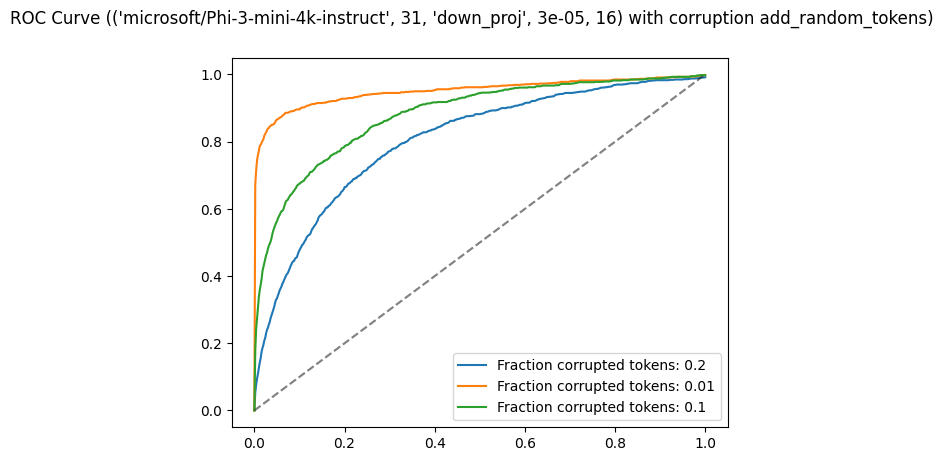

In [36]:
grid_size = 500
fig, ax = plt.subplots()
for key, data in data_param.items():
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)

    auc = get_auc(grid, cdf)
    print(f"AUC for fraction corrupted tokens {key}: {auc:.4f}")

    ax.plot(grid, cdf, label=f'Fraction corrupted tokens: {key}')
    ax.plot(grid, grid, linestyle='--', color='black', alpha=0.2)

ax.legend()
if block_size != -1:
    title = f'ROC Curve ({model_attributes} with corruption {corruption_type} block_size {block_size})'
else:
    title = f'ROC Curve ({model_attributes} with corruption {corruption_type})'

fig.suptitle(f'ROC Curve ({model_attributes} with corruption {corruption_type})')
plt.show()

# Roundtrip translation

In [24]:
parent = './amlt/09-06-roundtrip-detection'

roundtrip_generations, roundtrip_data = {}, {}

for dirname in os.listdir(parent):
    path = os.path.join(parent, dirname)
    model_key = get_model_key(path)
    with open(os.path.join(path, 'generations.json')) as f:
        gens = json.load(f)
    
    roundtrip_generations[model_key] = gens
    roundtrip_data[model_key] = get_all(gens, min_pval=1e-18)


/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
sig_pval = 0.05
num_passed = {}
log_probs_diff = {}
for key, datum in roundtrip_data.items():
    num_passed[key] = datum[datum['pvalue'] < sig_pval].shape[0] / datum.shape[0]
    log_probs_diff[key] = datum['logprob_diff_per_token'].mean()


print(f"Significance threshold: {sig_pval:.4f}")
for key in num_passed.keys():
    print(f"Fraction significant generations {key}: {num_passed[key]:.4f}")


Significance threshold: 0.0500
Fraction significant generations ('mistralai/Mistral-7B-v0.3', 30, 'up_proj', 1e-05, 4): 0.2252
Fraction significant generations ('microsoft/Phi-3-mini-4k-instruct', 31, 'down_proj', 3e-05, 16): 0.3741
Fraction significant generations ('meta-llama/Meta-Llama-3.1-8B', 30, 'down_proj', 0.0001, 4): 0.2553
Fraction significant generations ('mistralai/Mistral-7B-v0.3', 30, 'up_proj', 1e-05, 0): 0.1952
Fraction significant generations ('meta-llama/Meta-Llama-3.1-8B', 31, 'up_proj', 3e-05, 4): 0.3497


AUC ('mistralai/Mistral-7B-v0.3', 30, 'up_proj', 1e-05, 4): 0.6431
AUC ('microsoft/Phi-3-mini-4k-instruct', 31, 'down_proj', 3e-05, 16): 0.8139
AUC ('meta-llama/Meta-Llama-3.1-8B', 30, 'down_proj', 0.0001, 4): 0.7463
AUC ('mistralai/Mistral-7B-v0.3', 30, 'up_proj', 1e-05, 0): 0.6683
AUC ('meta-llama/Meta-Llama-3.1-8B', 31, 'up_proj', 3e-05, 4): 0.8050


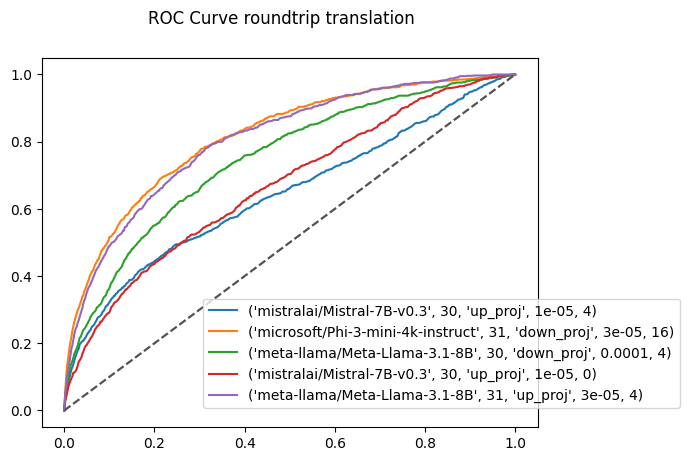

In [11]:
grid_size = 500
fig, ax = plt.subplots()
for key, data in roundtrip_data.items():
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)

    auc = get_auc(grid, cdf)
    print(f"AUC {key}: {auc:.4f}")

    ax.plot(grid, cdf, label=f'{key}')
    ax.plot(grid, grid, linestyle='--', color='black', alpha=0.2)

ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.2))

title = f'ROC Curve roundtrip translation'
fig.suptitle(title)
plt.show()

In [12]:
roundtrip_data.keys()

dict_keys([('mistralai/Mistral-7B-v0.3', 30, 'up_proj', 1e-05, 4), ('microsoft/Phi-3-mini-4k-instruct', 31, 'down_proj', 3e-05, 16), ('meta-llama/Meta-Llama-3.1-8B', 30, 'down_proj', 0.0001, 4), ('mistralai/Mistral-7B-v0.3', 30, 'up_proj', 1e-05, 0), ('meta-llama/Meta-Llama-3.1-8B', 31, 'up_proj', 3e-05, 4)])

In [13]:
round = roundtrip_data[('meta-llama/Meta-Llama-3.1-8B', 31, 'up_proj', 3e-05, 4)]

In [14]:
round[round['pvalue'] < 0.01].shape[0] / round.shape[0]

0.13326653306613226

# Example Text

In [15]:
idx = np.random.choice(len(generations[model_key][corruption_type][0.1]))



gens_param = generations[model_key][corruption_type]

print(f"Model: {model_key}")
print(f"Corruption: {corruption_type}")
print(f"Index {idx}\n")
for key, val in gens_param.items():

    print(f"({key}) {val[idx]['prompt'] + val[idx]['response']}\n")



KeyError: ('meta-llama/Meta-Llama-3.1-8B', 31, 'up_proj', 3e-05, 4)

# Old

# parent = './amlt/09-03-roundtrip-corruption-gemma'

# generations = get_generations(parent, _get_params=_get_params_llama)



min_prob = 1e-14


param_data = {  
    'rank': 4,
    'layer': 25,
    'mlp_type': 'down_proj'
    # 'mlp_type': 'up_proj'
    # 'mlp_type': 'gate_proj'
    # 'layer': -1,
    # 'mlp_type': 'weight'
}
param = get_title(param_data)


generations_param = {(_get_rank(key[0]),key[1], _get_mlp_type(key[0])): value for key, value in generations.items() if check_match(key, param_data)}
data_param = {key: get_all(value, min_prob) for key, value in generations_param.items()}


